In [38]:
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Embedding, LSTM, Flatten, Dense, Dropout
from keras import optimizers

import pandas as pd
import os
import numpy as np
import re

In [132]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal):
    """
    time_series
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [4]:
def normalize_all_signals_in_ds(one_group_ds):
    drop_cols = ['t'] if 't' in one_group_ds.columns else []
    for signal in one_group_ds.drop(drop_cols, axis=1):
        one_group_ds[signal] = normalize_signal(one_group_ds[signal])

In [5]:
oldpwd = os.getcwd()
print(oldpwd)

/home/poligon/master_degree


In [28]:
# os.chdir(oldpwd)
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [29]:
def append_signals_np_array(data_directory, signals_np_array = None, labels = None):
    drop_cols = ['Us', 'Pgt', 'Pij', 't']
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*\.csv)', filename):
                if (signals_np_array) is not None:
                    tmp_ar = pd.read_csv(filename).drop(drop_cols, axis=1)
                    normalize_all_signals_in_ds(tmp_ar)
#                     print(tmp_ar.values.T.reshape(-1, 1))
                    signals_np_array = np.append(signals_np_array, tmp_ar.values.T.reshape(1, -1), axis=0)
                else:
                    signals_np_array = pd.read_csv(filename).drop(drop_cols, axis=1)
                    normalize_all_signals_in_ds(signals_np_array)
                    signals_np_array = signals_np_array.values.T.reshape(1, -1)
#                     print(signals_np_array)
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_np_array, labels

In [30]:
labelizer = LabelEncoder().fit(labels['class'])
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    labels_df['label'] = labelizer.transform(labels_df['class'])
    labels_df.index = labels_df['id']
    labels_df.drop(columns=['id'])

In [31]:
# Dataset for first gen
X_train, labels_train = append_signals_np_array('./data/gen_1_25')
X_train, labels_train = append_signals_np_array('./data/gen_3_25', X_train, labels_train)
# dataset, labels = append_signals_dataset('./data/gen_1_80', dataset, labels)
# Dataset for second gen
X_val, labels_val = append_signals_np_array('./data/gen_1_80')
X_val, labels_val = append_signals_np_array('./data/gen_2_80', X_val, labels_val)
X_val, labels_val = append_signals_np_array('./data/gen_3_80', X_val, labels_val)

In [32]:
print(X_train.shape, X_val.shape)

(101, 600) (171, 600)


In [19]:
normalize_labels(labels_train)
normalize_labels(labels_val)

In [20]:
Y_train = labels_train.label.values
Y_val = labels_val.label.values

In [35]:
# X & Y dims check
assert X_train.shape[0] == Y_train.shape[0]
assert X_val.shape[0] == Y_val.shape[0]

In [36]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_val, Y_val = shuffle(X_val, Y_val, random_state=42)

In [37]:
X_train.shape

(101, 600)

## Using fully-connected NN

In [ ]:
# History data
historical_hp = pd.DataFrame(columns=['n_'])

In [316]:
# Hyperparametrs
EPOCHS = 2400
n_0 = X_train.shape[1]
n_1 = 80
# n_2 = 30
n_3 = 80
n_4 = len(labelizer.classes_)
lr = 1e-3

In [317]:
model = Sequential()
model.add(Dense(n_1, input_dim=n_0, activation='relu'))
# model.add(Dense(n_2, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(n_3, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_4, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [318]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 80)                48080     
_________________________________________________________________
dense_98 (Dense)             (None, 80)                6480      
_________________________________________________________________
dropout_39 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 3)                 243       
Total params: 54,803
Trainable params: 54,803
Non-trainable params: 0
_________________________________________________________________


In [319]:
model.predict(X_val[:10])

array([[0.16523603, 0.0824333 , 0.7523307 ],
       [0.19547483, 0.07124487, 0.73328024],
       [0.19655272, 0.07194407, 0.7315031 ],
       [0.18517332, 0.06525714, 0.74956954],
       [0.17632209, 0.08171769, 0.7419601 ],
       [0.16195016, 0.076182  , 0.7618679 ],
       [0.1169642 , 0.07752497, 0.8055108 ],
       [0.14972734, 0.09033155, 0.7599412 ],
       [0.09306788, 0.15722062, 0.74971145],
       [0.10077678, 0.12082437, 0.7783989 ]], dtype=float32)

In [320]:
history = model.fit(X_train, Y_train,
                    epochs=EPOCHS,
                    verbose=0,
                    validation_data=(X_val, Y_val)
                   )

In [321]:
history_df = pd.DataFrame(history.history)
history_df['val_loss'] = history_df['val_loss'] / history_df['val_loss'].max()
history_df['loss'] /= history_df['loss'].max()

In [322]:
history_df.val_accuracy.max()

0.7543859481811523

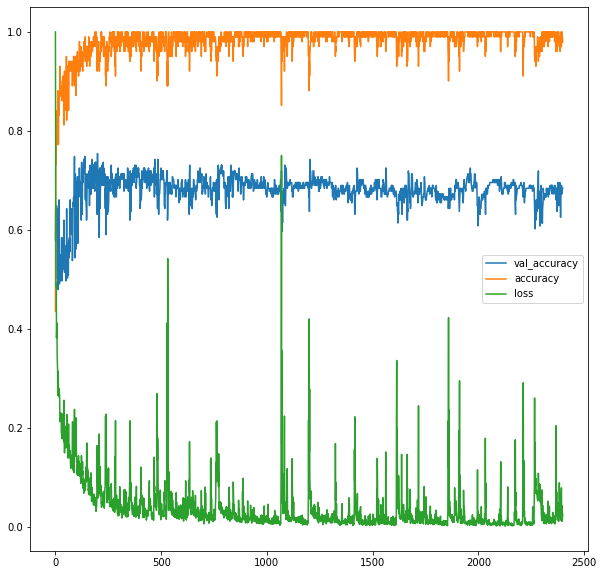

In [323]:
plt.figure(figsize=(10,10))
plt.plot(history_df.index, history_df['val_accuracy'])
plt.plot(history_df.index, history_df['accuracy'])
plt.plot(history_df.index, history_df['loss'])
# plt.plot(history.index, history['loss'])
plt.legend(['val_accuracy', 'accuracy', 'loss'])
plt.show()

In [324]:
y_pred = model.predict_classes(X_val)

In [325]:
confusion_matrix(Y_val, y_pred)

array([[50,  0,  0],
       [ 0,  8, 37],
       [ 5, 12, 59]])

In [304]:
# model.save('best_model.h5')

In [179]:
X_train_3d = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)

In [292]:
X_test_3d = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [381]:
model = Sequential()
model.add(Conv1D(32, 10, padding='same', activation='relu', input_shape=(TIME_PERIODS,1)))
model.add(MaxPooling1D(pool_size=10))
model.add(Conv1D(64, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [384]:
model.metrics_names

['loss', 'accuracy']

In [385]:
model.evaluate(X_test_3d, y_test)

8/8 [==============================] - 0s 27ms/step


[0.5827293395996094, 0.875]

In [278]:
import keras.metrics

In [ ]:
keras.metrics.accuracy